In [1]:
%matplotlib inline
import pandas as pd
figsize = (12, 6)

In [2]:
def suffix_to_bytes(suffixed_str):
    n, suffix = suffixed_str[0:-1], suffixed_str[-1] 
    if suffix == 'k':
        return int(float(n) * 1000)
    elif suffix == 'M':
        return int(float(n) * 1000**2)
    else:
        # not actually suffixed
        return int(suffixed_str)

In [3]:
df = pd.read_csv('sliderule_2017-01-11-03:18-full.csv', comment='#').dropna(how='all', axis=1)
names = df.pop('name')
splits = names.str.extract('<(?P<N>\d+)>/(?P<Threads>\d+)/(?P<PartSize>[\w.]+)')
df = df.combine_first(splits)
df = df.set_index(['Threads', 'N', 'PartSize'])

/home/dgq/.virtualenvs/jupyter3/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()


In [4]:
single_thread = df.loc[1]
threads_idx_idx = df.index.names.index('Threads')
threads = df.index.levels[threads_idx_idx]
num_threads_multi = threads[threads <= 4]

In [5]:
speedups = {}
efficiency = {}
for nt in num_threads_multi[1:]:
    speedups[int(nt)] = single_thread['real_time'] / df.loc[int(nt)]['real_time']
    efficiency[int(nt)] = speedups[int(nt)] / float(nt)

In [ ]:
best_times_single_thread = single_thread.real_time.groupby(level=0).min()

best_times_single_thread.index = best_times_single_thread.index.map(int)

iterdf = pd.read_csv('sliderule_2016-05-10-21:02-iter.csv', comment='#').dropna(how='all', axis=1)

names = iterdf.pop('name')
splits = names.str.extract('<(?P<N>\d+)>/[\w.]+')

iterdf['N'] = splits
iterdf = iterdf.set_index(['N'])
iterdf = iterdf.real_time
iterdf.index = iterdf.index.map(int)

iter_vs_singlethread = pd.concat([iterdf, best_times_single_thread], axis=1).dropna()
iter_vs_singlethread.columns = ('iter', 'st')

st_speedup = iter_vs_singlethread.apply(lambda row: row[0]/row[1], axis=1)

ax = st_speedup.plot(rot=35, grid=True, style='ro-', figsize=figsize,fontsize=16)

ax.set_xlabel('Polynomial Degree',  {'fontsize': 14})
ax.set_ylabel('Speedup',  {'fontsize': 14})

ax.set_title('Parallel vs. Iterative Speedup', {'fontsize': 16})
ax.axhline(y=1.0, c='k', lw=2)
fig = ax.get_figure()
fig.savefig('/tmp/parallel_vs_iter_speedup.pdf')

best_times_single_thread = single_thread.real_time.groupby(level=0).idxmin()
best_times_single_thread

# Efficiency
A better metric than the speedup is the efficiency, which simply normalizes the speedup by the number of threads. Therefore, an efficiency of $1$ would correspond to a speedup equal to the number of threads used. Efficiencies $> 1$ can be explained by cache effects, as a result of properly sized subproblems.

In [6]:
efficiency = pd.DataFrame(efficiency)
eff_grouped_by_N = efficiency.groupby(level=0)

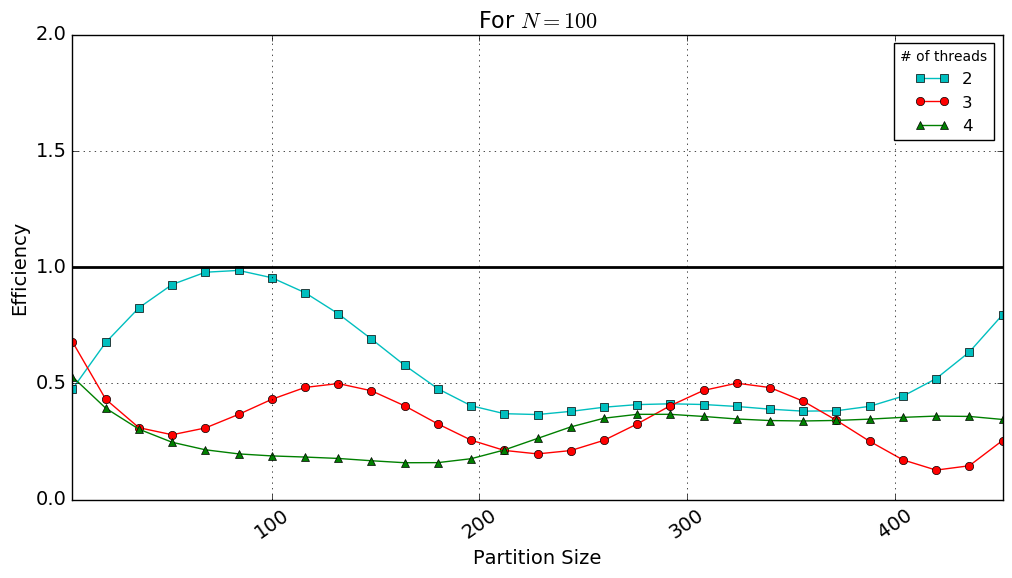

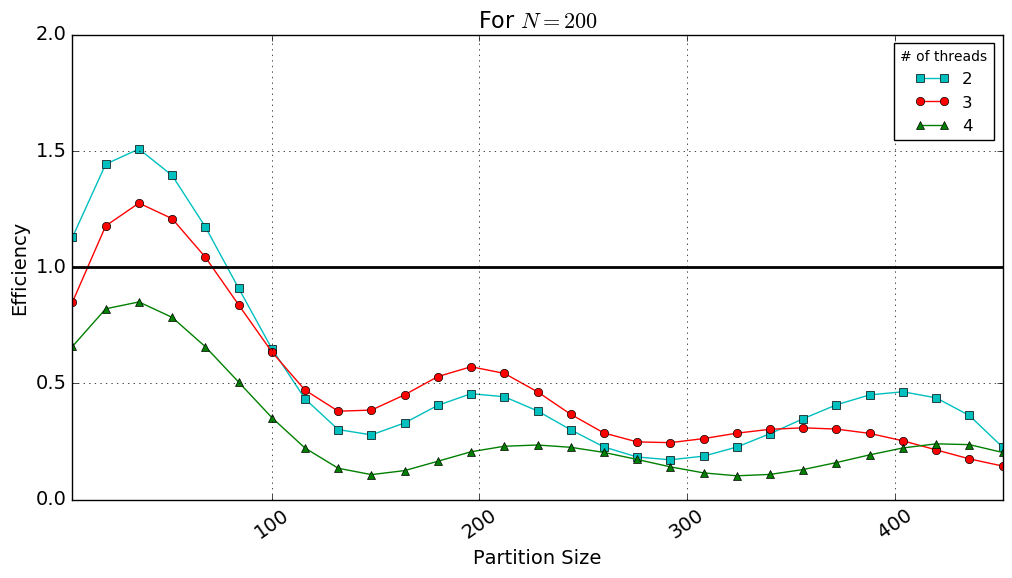

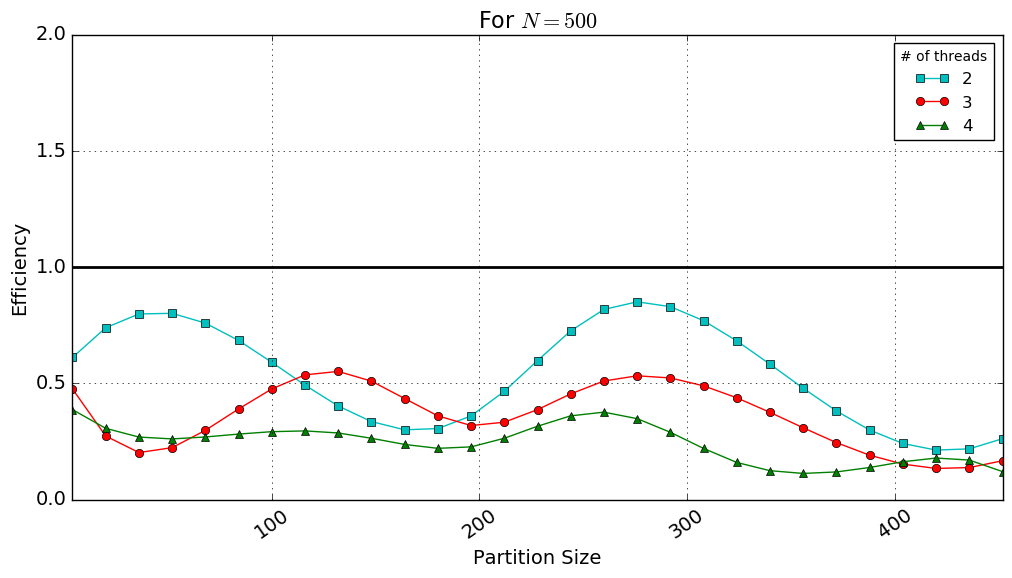

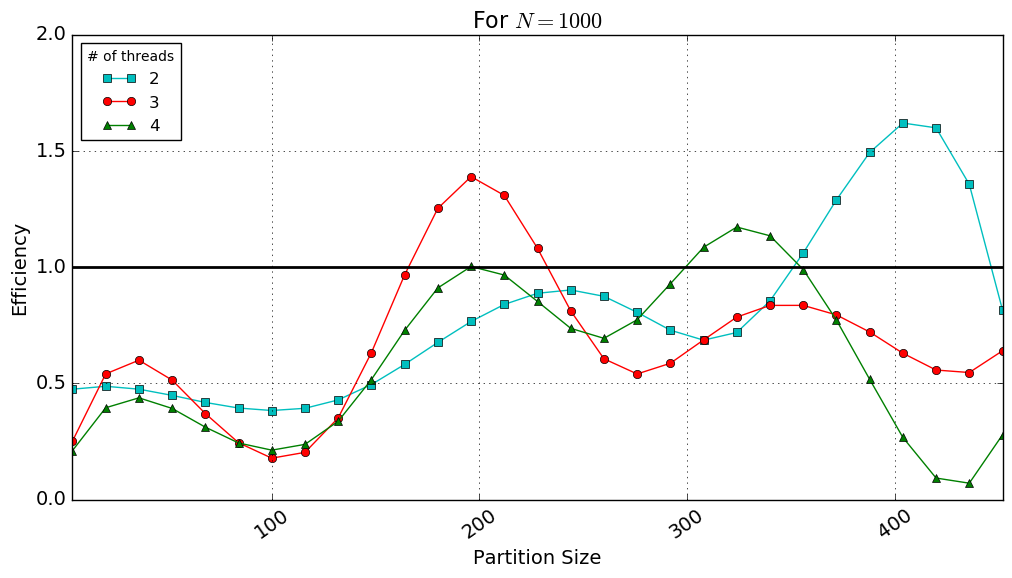

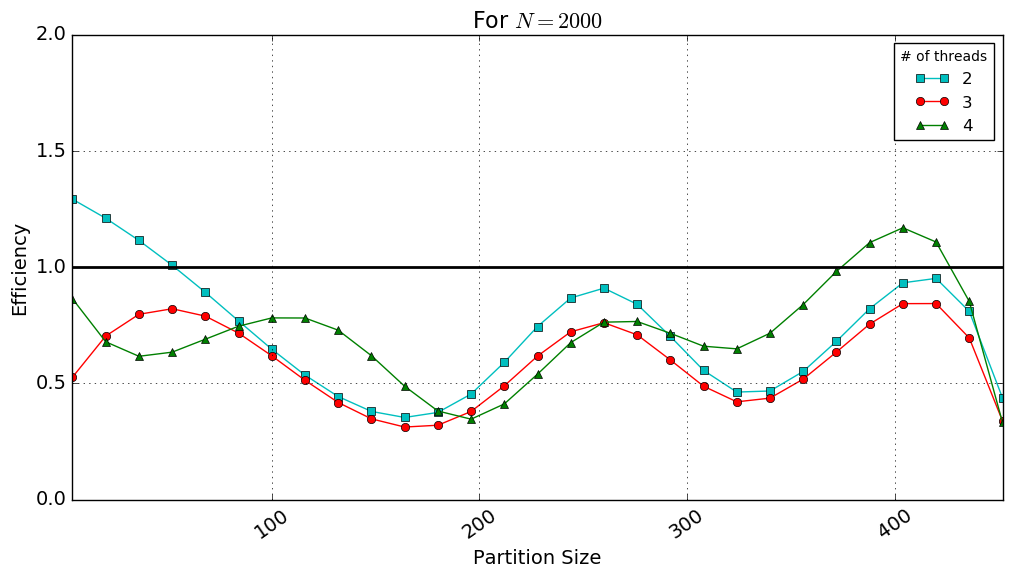

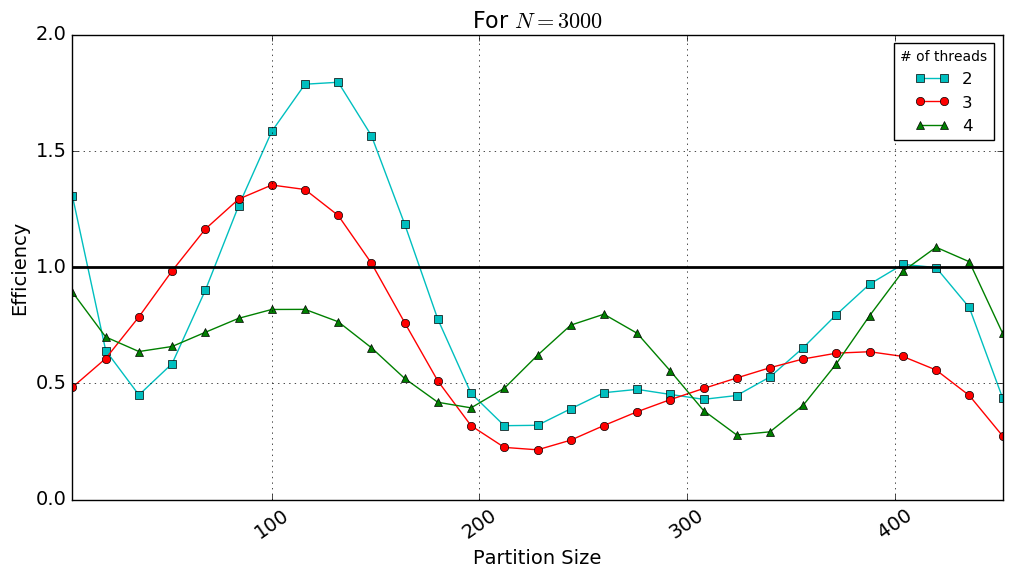

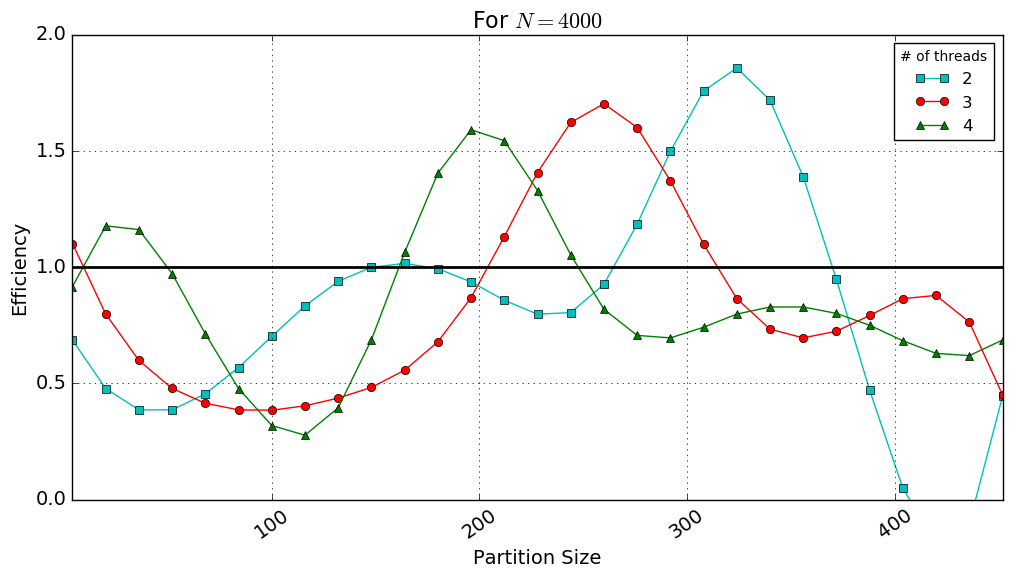

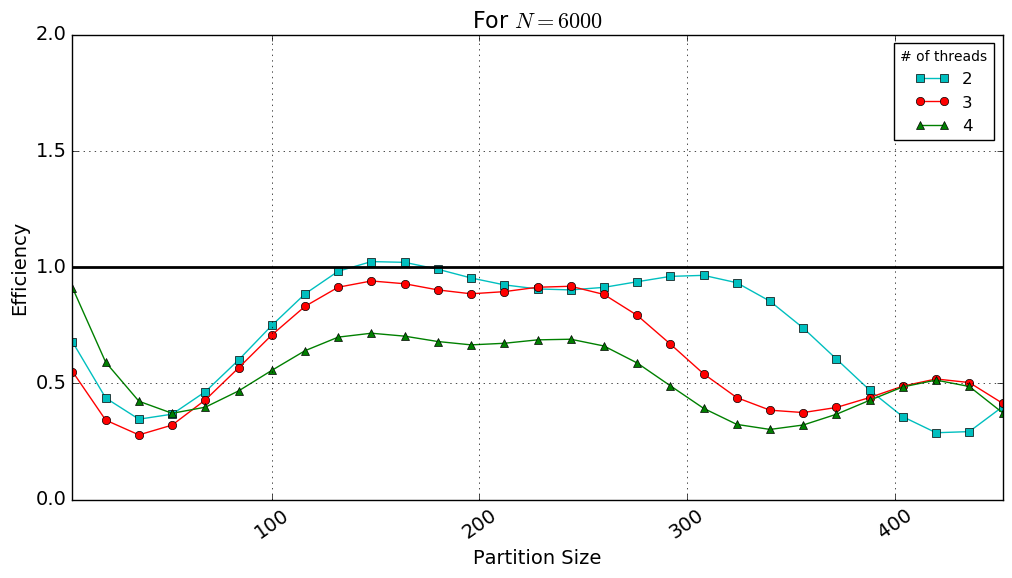

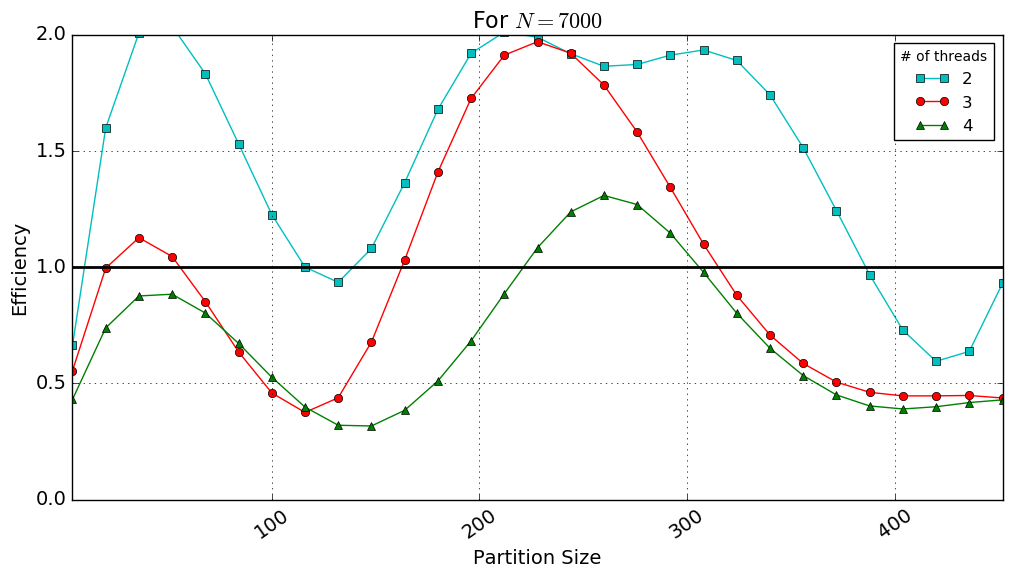

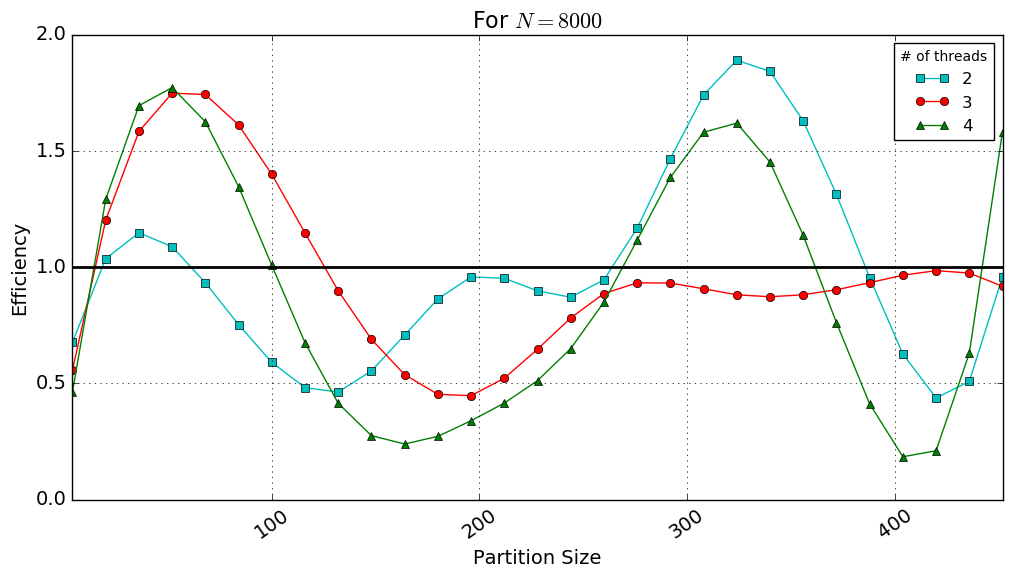

In [7]:
for name, group in eff_grouped_by_N:
    downsampled = group.loc[::16,2:6]
    downsampled.index = downsampled.index.droplevel()
    max_n = int(downsampled.index.max())+1
    interpolated = downsampled.reindex(pd.Index(range(4, max_n, 16))).interpolate(method='cubic')
    ax = interpolated.plot(rot=35, grid=True, style=['cs-', 'ro-', 'g^-', 'kv-', 'bD-'], 
                           figsize=figsize,
                           fontsize=14)
    ax.set_ylim(0, 2)
    ax.set_xlabel('Partition Size',  {'fontsize': 14})
    ax.set_ylabel('Efficiency',  {'fontsize': 14})
    ax.set_title('For $N = {}$'.format(int(name)), {'fontsize': 16})
    ax.axhline(y=1.0, c='k', lw=2)
    ax.get_legend().set_title('# of threads')
    fig = ax.get_figure()
    #fig.savefig('/tmp/{}.pdf'.format(int(name)))

# Maximum efficiencies per degree (N) and number of threads.

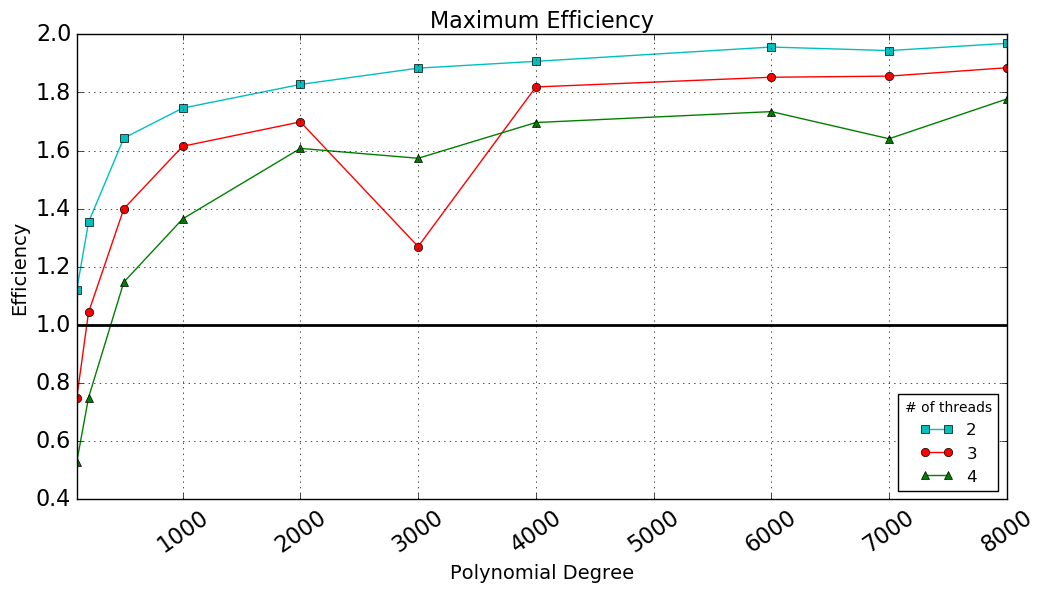

In [9]:
max_eff = efficiency.groupby(level=['N']).max()

ax = max_eff.plot(grid=True, rot=35, figsize=figsize, style=['cs-', 'ro-', 'g^-', 'kv-', 'bD-'], fontsize=16)
ax.set_xlabel('Polynomial Degree',  {'fontsize': 14})
ax.set_ylabel('Efficiency',  {'fontsize': 14})
ax.set_title('Maximum Efficiency', {'fontsize': 16})
ax.axhline(y=1.0, c='k', lw=2)
ax.get_legend().set_title('# of threads')
fig = ax.get_figure()
fig.savefig('/tmp/max_eff.pdf')

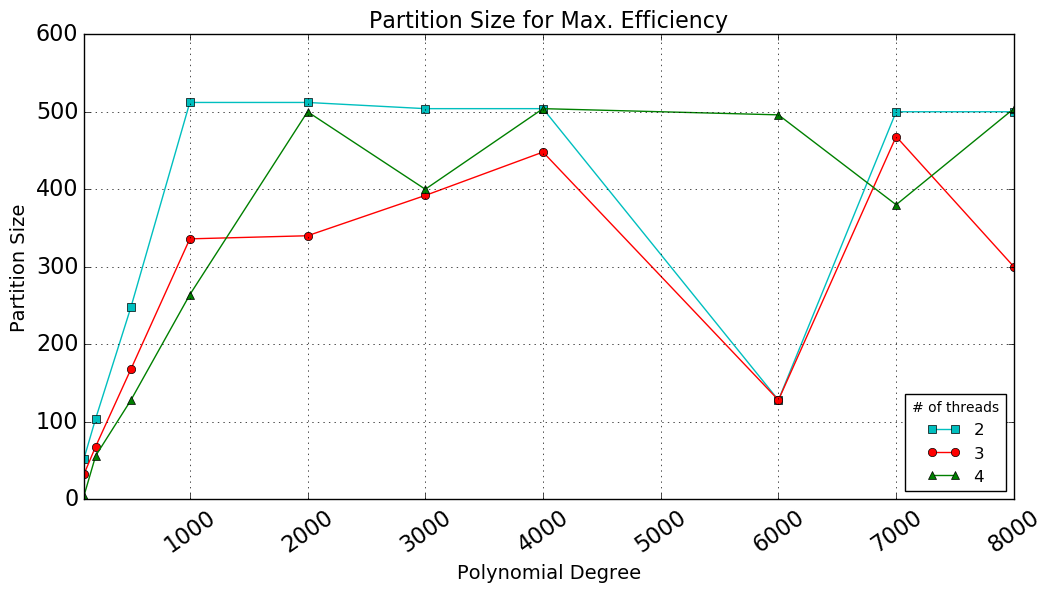

In [10]:
idx_max_eff = efficiency.groupby(level=['N']).idxmax().apply(lambda x: x.apply(lambda y: y[1]), axis=1)

ax = idx_max_eff.plot(grid=True, rot=35, figsize=figsize, style=['cs-', 'ro-', 'g^-', 'kv-', 'bD-'], fontsize=16)
ax.set_xlabel('Polynomial Degree',  {'fontsize': 14})
ax.set_ylabel('Partition Size',  {'fontsize': 14})
ax.set_title('Partition Size for Max. Efficiency', {'fontsize': 16})
ax.get_legend().set_title('# of threads')
fig = ax.get_figure()
fig.savefig('/tmp/max_eff_idx.pdf')